In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
sns.set(color_codes=True)
pal=sns.color_palette("Set2")
sns.set_palette(pal, 15)

## 1. 데이터 가져오기

In [51]:
data_dir = os.getenv('HOME')+'/aiffel/Exploration/06_kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(test_data_path)
train = pd.read_csv(train_data_path)  # 훈련 데이터셋(검증용 변도 분리)
test = pd.read_csv(test_data_path)   # 테스트, 즉 submission 시 사용할 데이터 경로

/aiffel/aiffel/Exploration/06_kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/Exploration/06_kaggle_kakr_housing/data/test.csv


#### 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [6]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## 2. 전처리 

### 상관계수를 이용한 특성변수 추출

In [8]:
# 가격을 기준으로 train데이터의 컬럼별 상관계수 산출하여 내림차순 정렬
np.abs(train.corr().price).sort_values(ascending=False)

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
bathrooms        0.525479
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
zipcode          0.051498
yr_built         0.047290
condition        0.039740
long             0.023547
id               0.020899
Name: price, dtype: float64

상관계수가 0.5이상인 price(1), sqft_living(0.702899), grade(0.667211), sqft_above (0.608577), sqft_living15 (0.586419), bathrooms (0.525479) 컬럼을 변수로한 회귀모형을 만들어 접근한다.

In [52]:
# 회귀는 상관관계가 높은 변수들의 가중치를 산출하는 문제다.
# 상관계수가 높은 변수들만 추출하여 머신러닝을 하여 가중치와 바이어스를 산출
train_col = ['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']
train = train[train_col]
train.head()

,price,sqft_living,grade,sqft_above,sqft_living15,bathrooms
0,221900.0,1180,7,1180,1340,1.00
1,180000.0,770,6,770,2720,1.00
2,510000.0,1680,8,1680,1800,2.00
3,257500.0,1715,7,1715,2238,2.25
4,291850.0,1060,7,1060,1650,1.50


### 특성변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

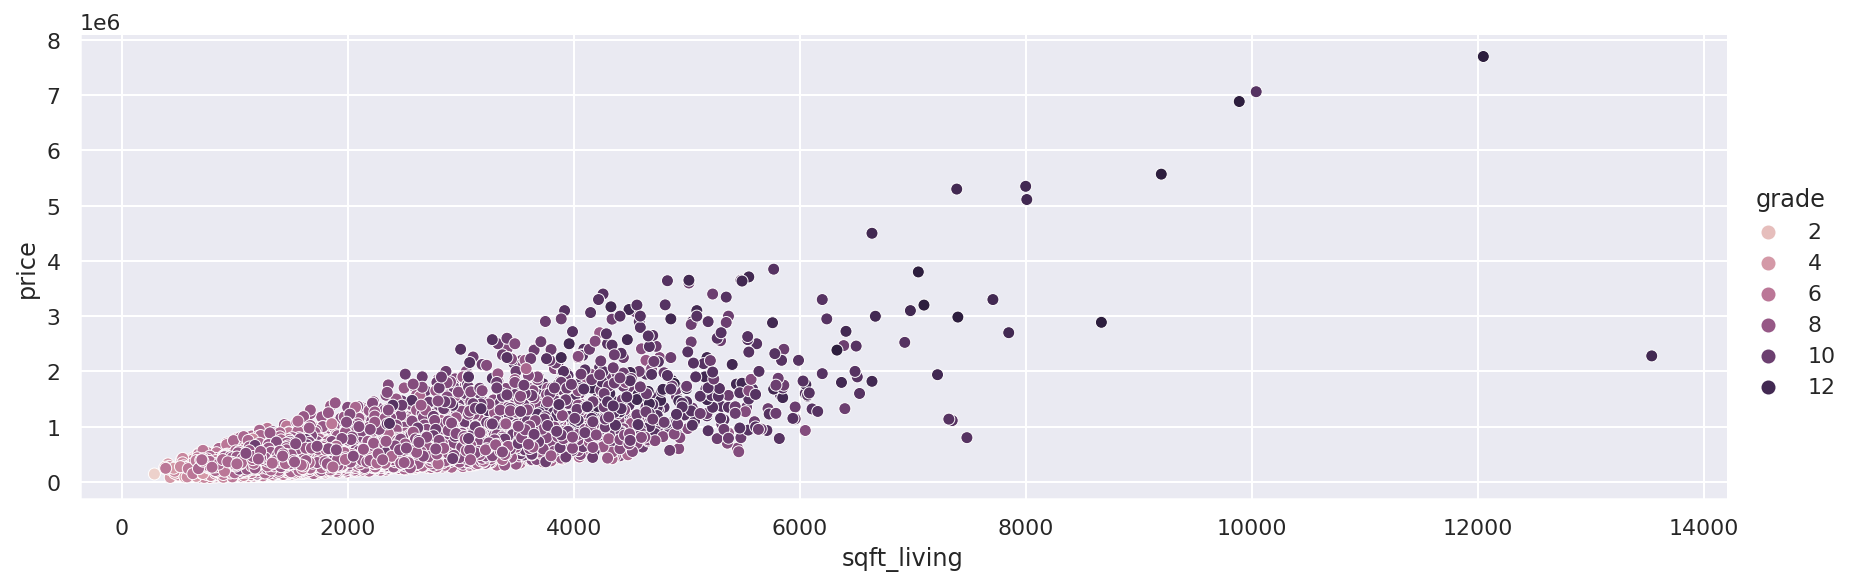

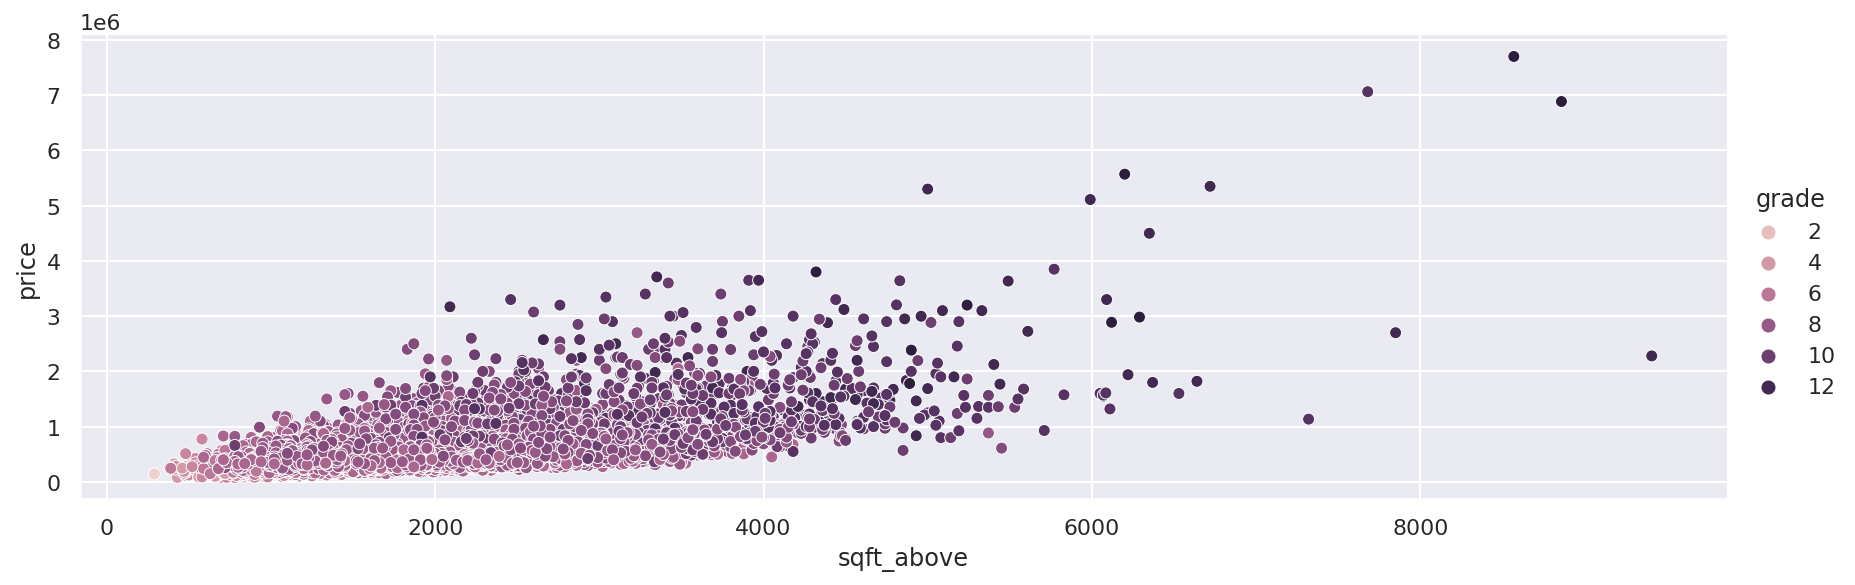

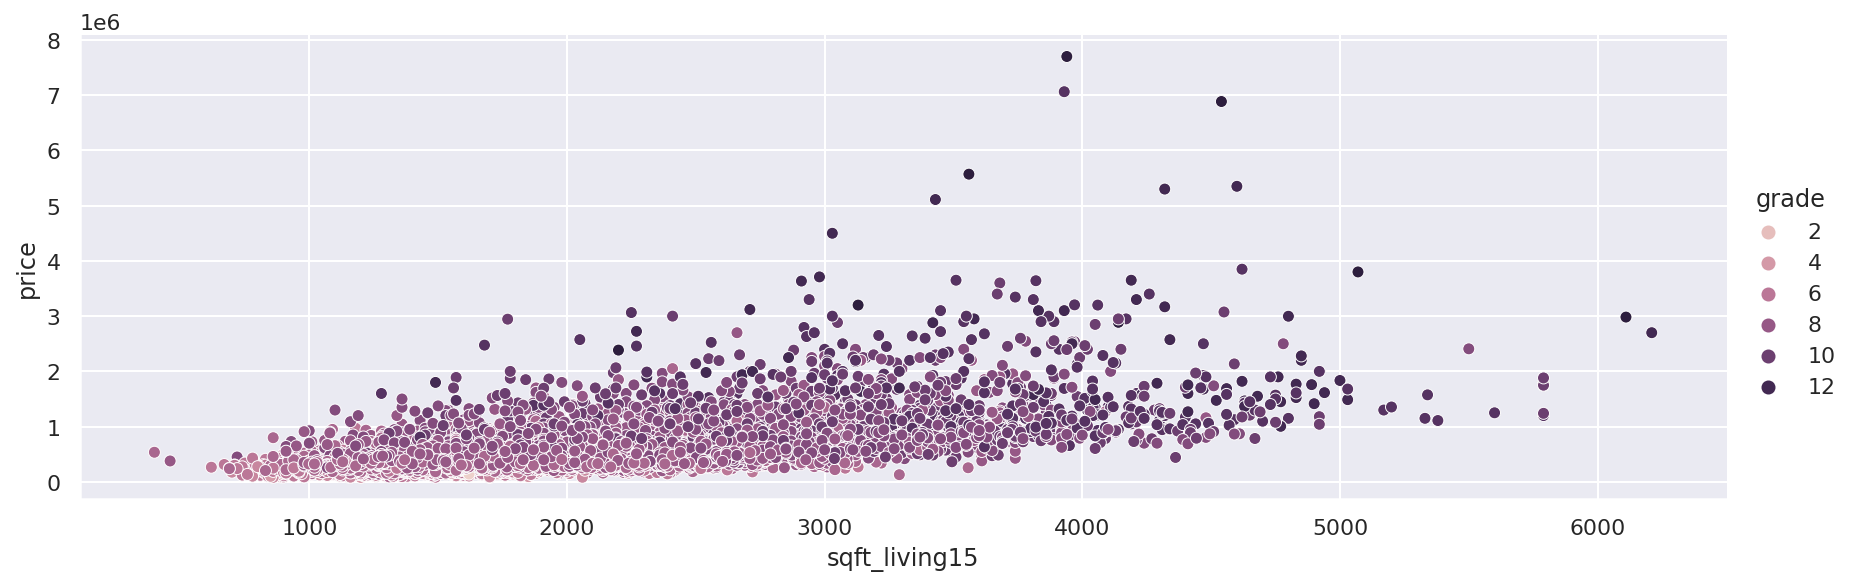

In [10]:
# 수치데이터의 상관관계를 그래프로 살펴본다.
relplot_col=['sqft_living', 'sqft_above', 'sqft_living15']
for col in relplot_col:
    sns.relplot(x=col,y='price',data=train, hue='grade', height=4,aspect=3); plt.show()

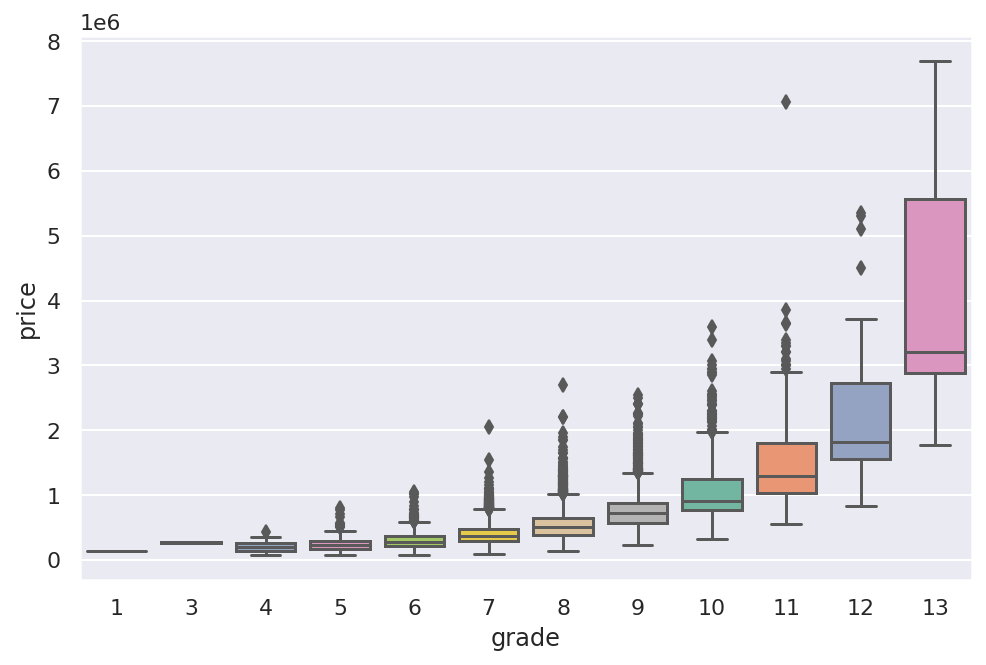

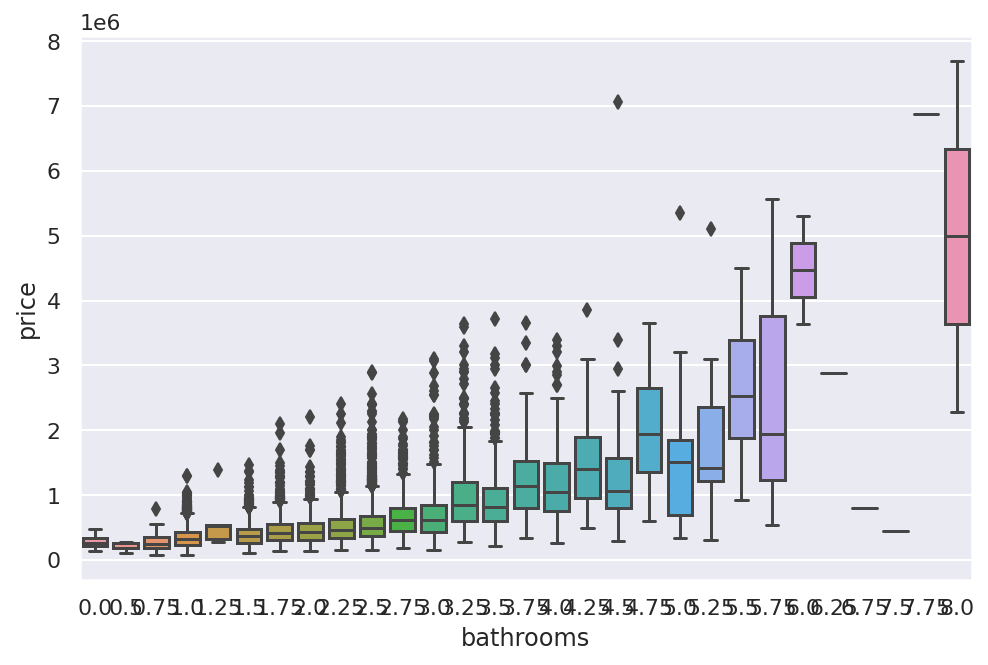

In [11]:
# 범주 데이터['grade', 'bathrooms']별로 가격분포를 박스플롯으로 분포도 파악
boxplot_col= ['grade', 'bathrooms']
for col in boxplot_col:
    plt.figure(figsize=(8,5))
    sns.boxplot(col,'price',data=train); plt.show()
    

가격의 하위에 높은 밀도를 보이는데, 치우쳐진 분포를 고른 분포로 하기 위해 price변수를 로그화시켜야 한다.

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [12]:
train['price']

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

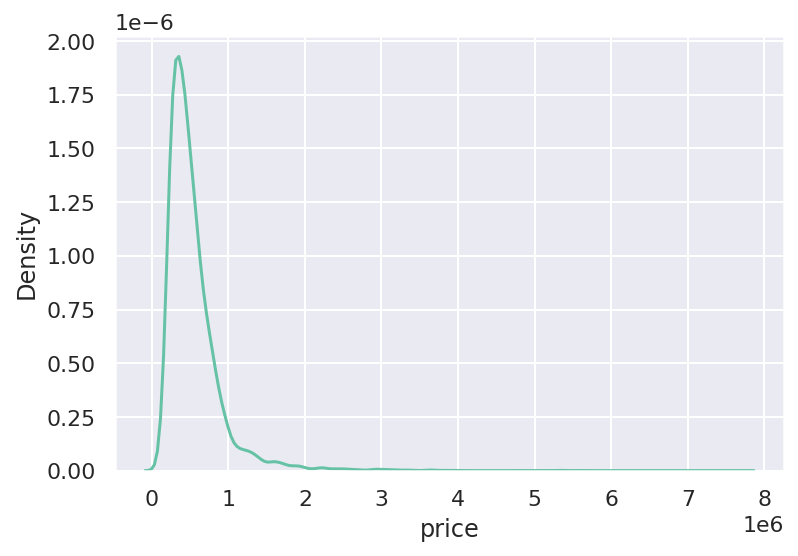

In [13]:
sns.kdeplot(train['price'])
plt.show()

### 가격 컬럼의 로그화

In [53]:
# 가격 컬럼을 로그화하고 새로운 컬럼을 만듬. np.log1p()함수 사용
train['price_log'] = np.log1p(train['price'])   
train['price_log']

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price_log, Length: 15035, dtype: float64

In [15]:
train.head()

,price,sqft_living,grade,sqft_above,sqft_living15,bathrooms,price_log
0,221900.0,1180,7,1180,1340,1.00,12.309987
1,180000.0,770,6,770,2720,1.00,12.100718
2,510000.0,1680,8,1680,1800,2.00,13.142168
3,257500.0,1715,7,1715,2238,2.25,12.458779
4,291850.0,1060,7,1060,1650,1.50,12.583999


#### 로그화된 가격 기준 분포도 재확인

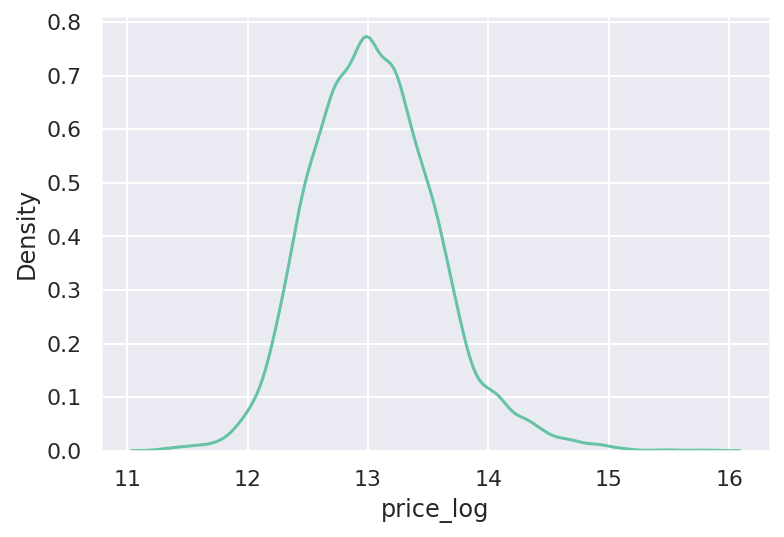

In [16]:
sns.kdeplot(train['price_log'])
plt.show()

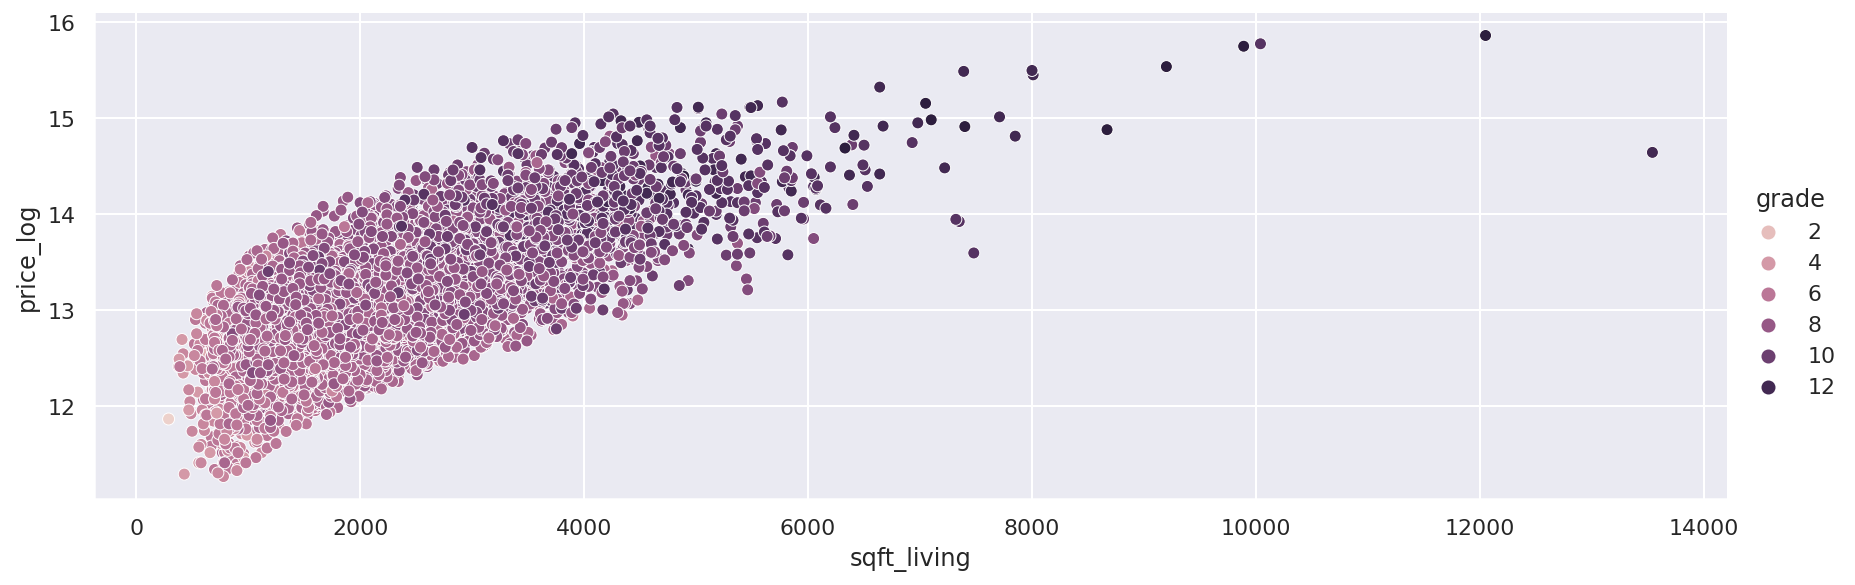

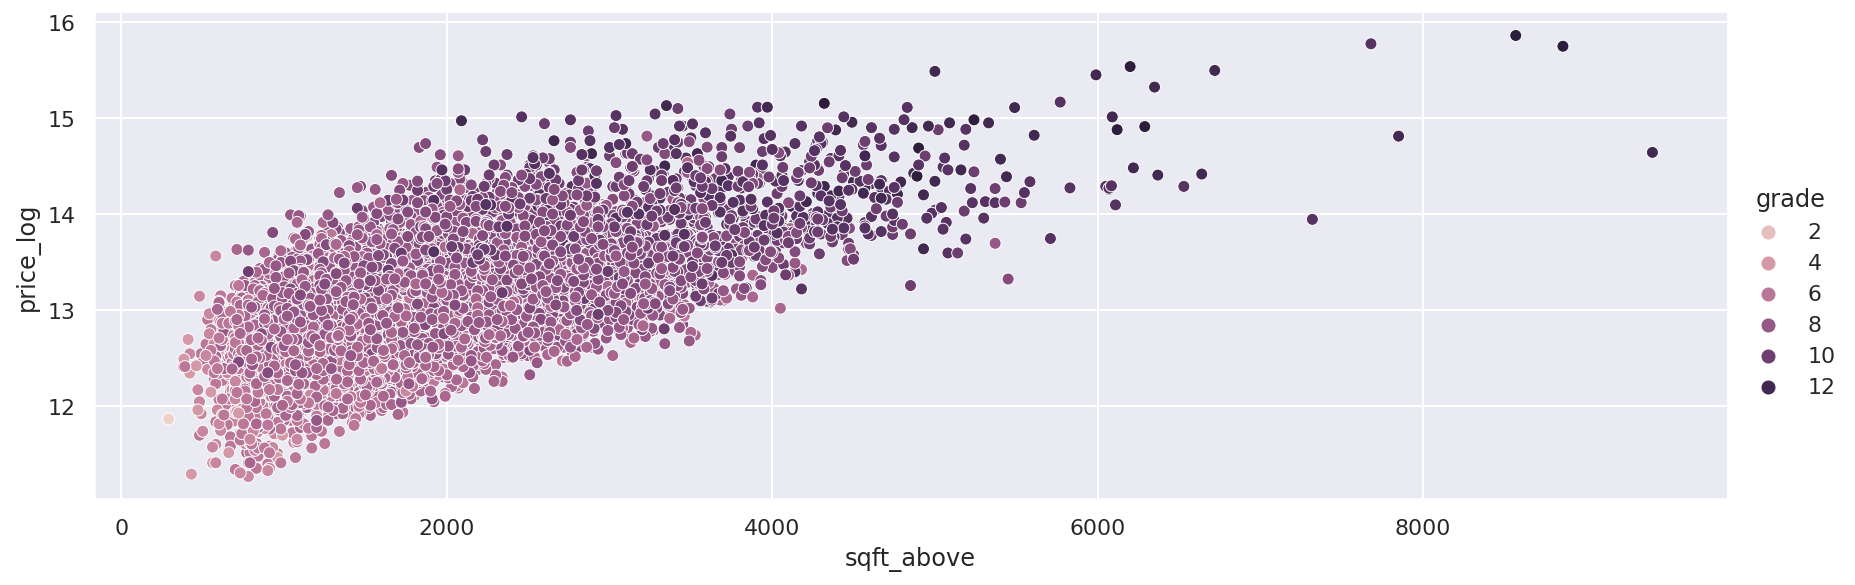

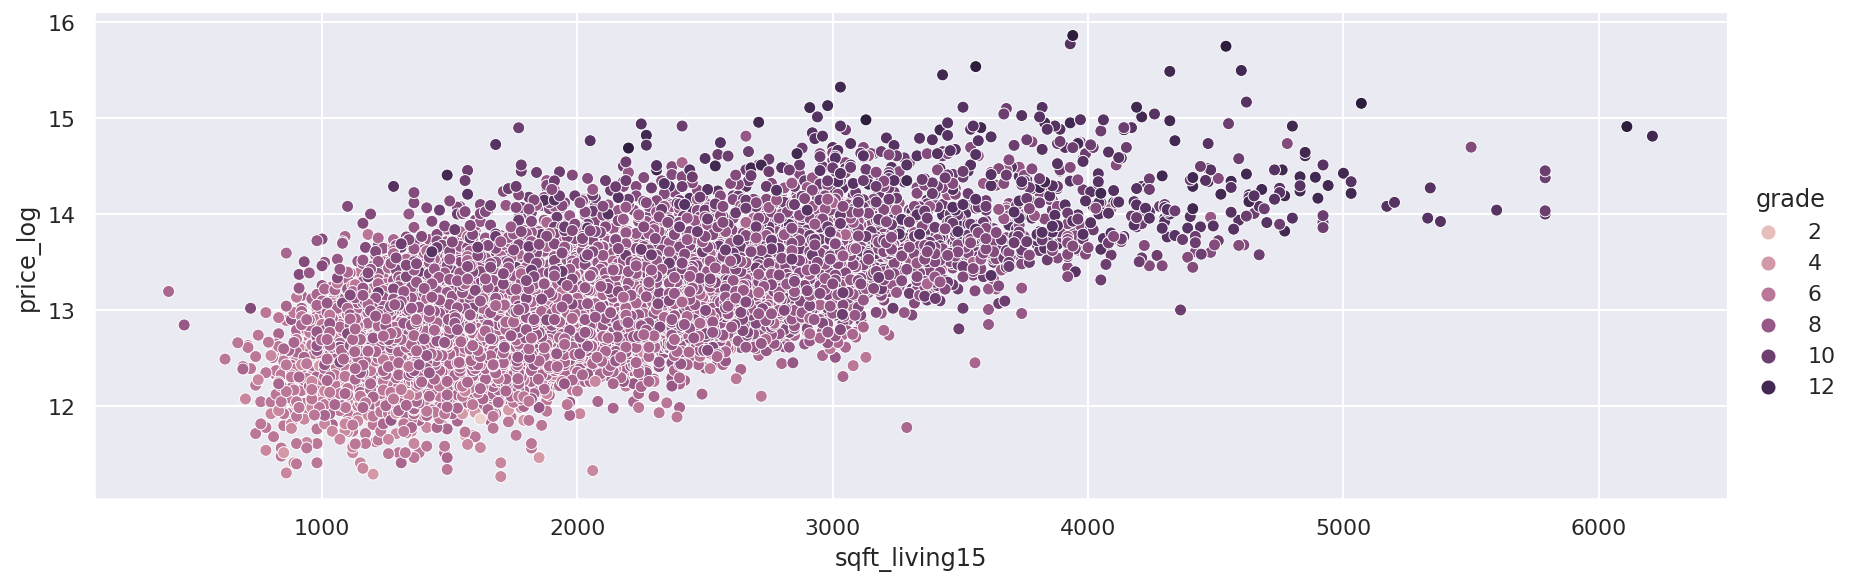

In [17]:
relplot_col=['sqft_living', 'sqft_above', 'sqft_living15']
for col in relplot_col:
    sns.relplot(x=col,y='price_log',data=train, hue='grade', height=4,aspect=3); plt.show()

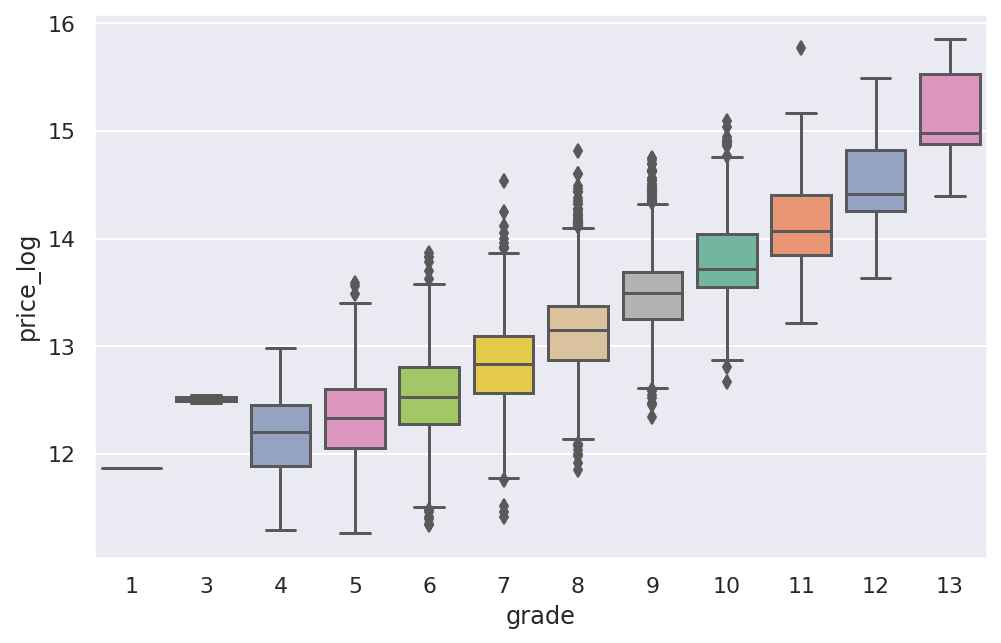

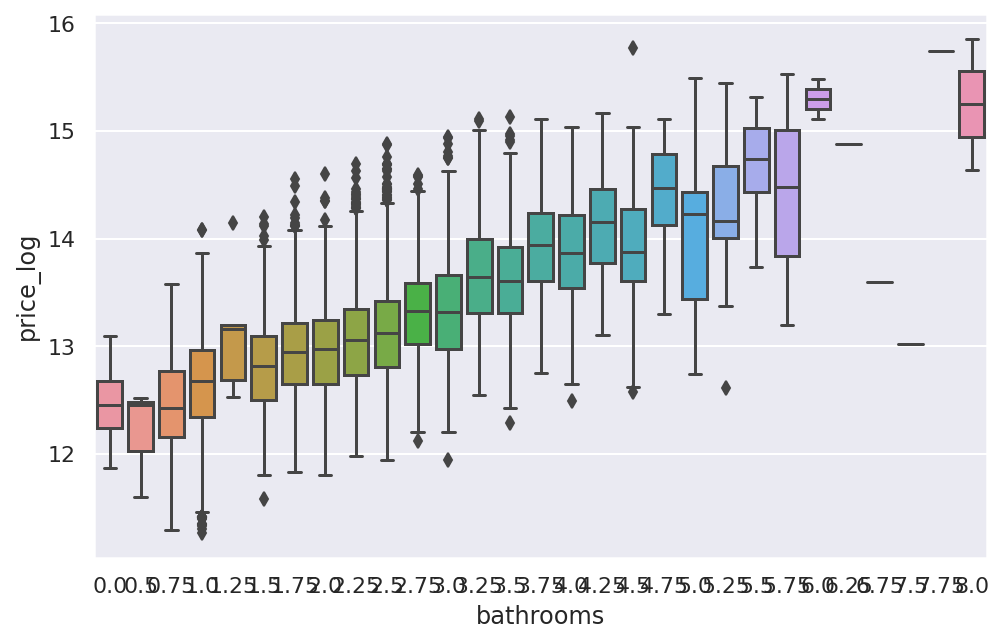

In [18]:
# 명목변수 ['grade', 'bathrooms']
boxplot_col= ['grade', 'bathrooms']
for col in boxplot_col:
    plt.figure(figsize=(8,5))
    sns.boxplot(col,'price_log',data=train); plt.show()
    

### 학습데이터셋의 라벨 변수 추출(price 컬럼) 및 특성변수 생성
train 데이터셋에서 제외. 먼저 y변수로 저장

In [19]:
train.head()

,price,sqft_living,grade,sqft_above,sqft_living15,bathrooms,price_log
0,221900.0,1180,7,1180,1340,1.00,12.309987
1,180000.0,770,6,770,2720,1.00,12.100718
2,510000.0,1680,8,1680,1800,2.00,13.142168
3,257500.0,1715,7,1715,2238,2.25,12.458779
4,291850.0,1060,7,1060,1650,1.50,12.583999


In [54]:
y = train['price_log']         # 라벨 훈련데이터셋 생성 (분포때문에 로그된 가격)

del train['price']             # 특성 훈련데이터셋 생성 (price, price_log 삭제)
del train['price_log']         # drop() 메서드 재시도 검토할 것
# train.drop(columns=["price", "price_log"])
print(train.columns)

Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms'], dtype='object')


### 제출용 테스트 데이터셋 전처리

In [23]:
test_col = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']
test_sub = test[test_col]

print(test_sub.columns)

Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms'], dtype='object')


## 3. 모델 튜닝
### (1) 모델 학습 및 성과측정 (여러 모델 실행)
#### RMES 계산(loss 함수)
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    # 오차함수는 원자료 price의 차이를 계산해야 하므로 로그가격을 복원해야함 
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


#### 모델별 오차산출 함수 생성

In [29]:
# 코드작성 과제
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [30]:
get_scores(models, train, y)

,RMSE
RandomForestRegressor,237979.136325
LGBMRegressor,237338.815843
GradientBoostingRegressor,232765.402690
XGBRegressor,231978.866069


### (2) Grid Search
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

#### 하이퍼 파라미터  설정

In [43]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}
print('하이퍼 파라미터를 설정하였습니다.')

얍💢


In [44]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [47]:
my_GridSearch(rdforest, train, y, param_grid, n_jobs=10)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    4.9s remaining:    3.3s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    8.7s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.113504,0.336903
2,10,50,-0.113805,0.337351
0,1,50,-0.181444,0.425963
1,1,100,-0.182223,0.426876


## 4. Make Submission

In [76]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    prediction = prediction.astype(int)        # 최종 가격을 정수로 변환
    data_dir = os.getenv('HOME')+'/aiffel/Exploration/06_kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [77]:
save_submission(model, train, y, test_sub, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/Exploration/06_kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


## 후기

1. 상관관계가 높은 변수로 특성변수를 구성하였는데 결과적으로 오차가 baseline보다 크게 나왔다.    
2. 시간이 촉박한 관계로 다른 조합을 하지 못했다. 다른 변수를 넣었을 때의 상관계수 변화 및 sqft당 가격 등 다양한 조합이 가능하리라 본다. 추후 시도해보기로 한다.  
3. 이번 노드에서 얻은 것은 함수 생성에 대한 자신감을 얻었다. 함수 작성을 위해 앞단에서 작업하는 것과 검증하는 작업을 충분히 하였다.    
4. 중간에 데이터셋 지정을 잘못하여 당혹했었는데 전체적인 데이터 흐름을 놓치지 말아야 한다는 교훈도 얻었다.